# Using external optimizers

The PyTorch package ships already with a [number of optimizers](https://pytorch.org/docs/stable/optim.html). These however are typically suited for problems with large parameter spaces (several hundred or more). For smaller problems other optimizers, e.g. the [Levenberg-Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm), are more efficient. The Scipy package offers various other optimizers at their [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) function. This notebook shows how to use such external optimizers together with the DiPAS framework.

In PyTorch the job of the optimizer is to update the parameters of the simulation, given their gradients with respect to some cost function. That is it performs the following steps:

1. Compute the new parameter values (based on the current values and gradients),
2. Apply these new values, i.e. make the changes effective.

We use the external optimizer to perform step (1) and then we apply the changes manually (which is easy).

## Setup

In this example we will estimate quadrupole gradient errors based on ORM matching. In the following we load the lattice, set some random errors and compute the reference ORM.

In [1]:
from dipas.build import from_file
import dipas.compute as compute
from dipas.elements import elements, Marker, Quadrupole, VKicker, VMonitor, tensor
import numpy as np
import torch


elements['multipole'] = lambda **kwargs: Marker()  # all multipoles are turned off

lattice = from_file('example.madx')
quadrupoles = lattice[Quadrupole]

k1 = np.array([q.k1.numpy() for q in quadrupoles])
errors = np.random.normal(scale=0.01*abs(k1), size=len(quadrupoles))

for q, dk1 in zip(quadrupoles, errors):
    q.dk1 = tensor(dk1)
    q.update_transfer_map()
    
orm_ref = compute.orm(lattice, kickers=VKicker, monitors=VMonitor, order=1)[1]  # vertical response only

Let's recall the signature of [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). It expects a function `func` which receives N parameters and outputs M residuals, both as Numpy arrays. The default `"lm"` (Levenberg-Marquardt) solver requires that `N <= M`. In our case the input N will be the current estimate of the quadrupole errors and the output M is the vertical ORM. The lattice contains 36 quadrupoles, 12 vertical correctors and 12 BPMs. So we have `N = 36` and `M = 12**2`.

Within that function `func` we need to make the new parameter estimate effective, similar to above, and then compute the ORM and return it as a flattened Numpy array.

In [2]:
print(f'# Quadruoles: {len(quadrupoles)}')
print(f'# Correctors: {len(lattice[VKicker])}')
print(f'# BPMs: {len(lattice[VMonitor])}')


def orm_func(estimate):
    for q, dk1 in zip(quadrupoles, estimate):
        q.dk1 = tensor(dk1)
        q.update_transfer_map()
    orm = compute.orm(lattice, kickers=VKicker, monitors=VMonitor, order=1)[1]
    residuals = (orm - orm_ref).numpy().ravel()
    return residuals

# Quadruoles: 36
# Correctors: 12
# BPMs: 12


The above function is sufficient however the algorithm would still need to estimate the Jacobian itself via finite difference approximation. The number of forward passes, i.e. ORM computations, is approximately on the order of the number of parameters, i.e. 37 in our case (1 baseline + 1 offset for each parameter). This means the algorithm would need to compute 37 different ORMs before it can estimate the Jacobian and provide a new parameter estimate. Here we can be more efficient by reusing the computation graph that is built by the simulation and compute all the gradients with a single forward-backward pass. For this we can use [`torch.autograd.functional.jacobian`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.jacobian). In order to do everything at once and also cache the result of the computation we can wrap everything in a dedicated class.

In [3]:
from collections import deque

from torch.autograd.functional import jacobian


class MatchORM:
    def __init__(self, lattice, orm_ref):
        self.lattice = lattice
        self.orm_ref = orm_ref
        self.quadrupoles = lattice[Quadrupole]
        self.jac_cache = deque(maxlen=1)
        self.orm_cache = deque(maxlen=1)
        self.step = 0
        
    def __call__(self, estimate):
        """This function gets invoked by least_squares, i.e. Numpy inputs/outputs."""
        self.step += 1
        jac = jacobian(self._compute, torch.from_numpy(estimate))
        self.jac_cache.append(jac.numpy())
        residuals = self.orm_cache.pop().detach().numpy()
        print(f'[{self.step:02d}] mse = {np.mean(residuals**2)}')
        return residuals
    
    def _compute(self, estimate):
        """This function gets invoked by jacobian, i.e. PyTorch inputs/outputs."""
        for q, dk1 in zip(self.quadrupoles, estimate):
            q.dk1 = dk1
            q.update_transfer_map()
        orm = compute.orm(lattice, kickers=VKicker, monitors=VMonitor, order=1)[1]
        residuals = torch.flatten(orm - self.orm_ref)
        self.orm_cache.append(residuals)
        return residuals
    
    def jac(self, estimate):
        """This function gets invoked by least_squares, i.e. Numpy output is required."""
        return self.jac_cache.pop()

Now we can invoke the optimizer by passing it an instance of this class:

In [4]:
from scipy.optimize import least_squares


match = MatchORM(lattice, orm_ref)

result = least_squares(match, jac=match.jac, x0=np.zeros_like(errors), method='lm')
print(result)

[01] mse = 2.3596129695680395
[02] mse = 2.3596129695680395
[03] mse = 2.3596129695680395
[04] mse = 0.04447263051378097
[05] mse = 0.019456070405029766
[06] mse = 6.416326049531289e-06
[07] mse = 3.7826057702729345e-09
[08] mse = 1.895252659297642e-19
[09] mse = 1.427573236173852e-27
[10] mse = 8.101062664219795e-28
 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 5.832765118238252e-26
         fun: array([ 0.00000000e+00,  5.32907052e-15, -5.32907052e-15,  8.88178420e-15,
        1.24344979e-14, -1.50990331e-14, -2.13162821e-14, -2.79221091e-14,
        5.32907052e-15,  0.00000000e+00, -4.08562073e-14,  1.77635684e-15,
        2.39808173e-14, -7.10542736e-15, -2.48689958e-14, -3.55271368e-15,
        2.13162821e-14, -8.88178420e-15, -3.64153152e-14, -1.24344979e-14,
       -1.99840144e-14, -5.15143483e-14, -2.22044605e-15,  7.10542736e-15,
        3.55271368e-15, -2.22044605e-14,  8.

Finally let's compare the results with the actual errors:

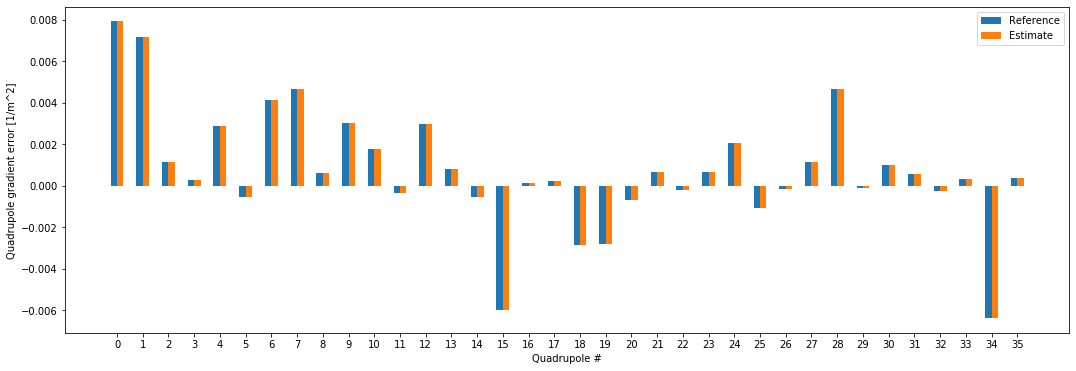

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(18, 6))
ax.set(xlabel='Quadrupole #', ylabel='Quadrupole gradient error [1/m^2]')
width = 0.25
x = np.arange(len(errors))
ax.bar(x - width/2, errors, width, label='Reference')
ax.bar(x + width/2, result.x, width, label='Estimate')
ax.set_xticks(x)
ax.legend()